In [ ]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import matplotlib.pyplot as plt
import pandas as pd
import re
from skimage.transform import resize
from keras import regularizers
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Cropping3D
from keras.models import Model
import numpy as np
from keras.models import Model
from matplotlib.patches import Patch
import matplotlib.image as mpimg
import cv2
import numpy as np
import glob


In [ ]:
# Amazon bounds
lat_min, lat_max = -15, 5
lon_min, lon_max = -75, -50

sif_amazon = []
time_list = []

data_dir = data_dir = "/Users/carmenoliver/Desktop/SIF_anomalies/SIF_DATA_TROPOMI/"

# Get all available files
files = sorted([f for f in os.listdir(data_dir) if f.endswith(".nc")])
print("Files found:", files)
for file in files:
    match = re.search(r"month-(\d{6})", file)
    if match:
        date_str = match.group(1)  
        year = int(date_str[:4])  
        month = int(date_str[4:6])  

        file_path = os.path.join(data_dir, file)
        
        try:
            ds = xr.open_dataset(file_path)
        except Exception as e:
            print(f"Error opening {file_path}: {e}")
            continue
        ds_amazon = ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
        
        sif_amazon.append(ds_amazon["solar_induced_fluorescence"].values)  
        time_list.append(f"{year}-{month:02d}")
        # Ensure data was loaded
if not sif_amazon or not time_list:
    raise ValueError("No valid data found. Check the input files and filtering logic.")
sif_amazon = np.stack(sif_amazon, axis=0).squeeze()  # Shape: [N_months, lat, lon]

years = sorted(set(int(t.split("-")[0]) for t in time_list))
num_years = len(years)

sif_monthly = np.full((num_years, 12, *sif_amazon.shape[1:]), np.nan)
for i, month_data in enumerate(sif_amazon):
    year_idx = i // 12  
    month_idx = i % 12  
    sif_monthly[year_idx, month_idx] = month_data 

print("Fixed sif_monthly shape:", sif_monthly.shape)

Files found: ['s5p-l3grd-sif-001-month-20190101-20240325.nc', 's5p-l3grd-sif-001-month-20190201-20240325.nc', 's5p-l3grd-sif-001-month-20190301-20240325.nc', 's5p-l3grd-sif-001-month-20190401-20240325.nc', 's5p-l3grd-sif-001-month-20190501-20240325.nc', 's5p-l3grd-sif-001-month-20190601-20240325.nc', 's5p-l3grd-sif-001-month-20190701-20240325.nc', 's5p-l3grd-sif-001-month-20190801-20240325.nc', 's5p-l3grd-sif-001-month-20190901-20240325.nc', 's5p-l3grd-sif-001-month-20191001-20240325.nc', 's5p-l3grd-sif-001-month-20191101-20240325.nc', 's5p-l3grd-sif-001-month-20191201-20240325.nc', 's5p-l3grd-sif-001-month-20200101-20240325.nc', 's5p-l3grd-sif-001-month-20200201-20240325.nc', 's5p-l3grd-sif-001-month-20200301-20240325.nc', 's5p-l3grd-sif-001-month-20200401-20240325.nc', 's5p-l3grd-sif-001-month-20200501-20240325.nc', 's5p-l3grd-sif-001-month-20200601-20240325.nc', 's5p-l3grd-sif-001-month-20200701-20240325.nc', 's5p-l3grd-sif-001-month-20200801-20240325.nc', 's5p-l3grd-sif-001-month-2

In [ ]:
has_nans = np.isnan(sif_monthly).any()
print("Does sif_monthly contain NaNs?", has_nans)
mean_sif_monthly = np.nanmean(sif_monthly)
sif_monthly = np.nan_to_num(sif_monthly, nan=mean_sif_monthly)
sif_monthly_climatology = sif_monthly[:5]  #Only from 2019-2023
print("sif_monthly_climatology shape:", sif_monthly_climatology.shape)
climatology = np.nanmean(sif_monthly_climatology, axis=0)

monthly_means = np.nanmean(climatology, axis=(1, 2)) 
overall_mean_sif = np.nanmean(monthly_means)

# Create a climatology table
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']
climatology_table = pd.DataFrame({
    'Month': months,
    'Avg SIF': np.round(monthly_means, 3) 
})

print("Monthly Climatology Summary:")
print(climatology_table)

print("\nOverall Mean SIF:", round(overall_mean_sif, 3))


Does sif_monthly contain NaNs? False
sif_monthly_climatology shape: (5, 12, 911, 1137)
Monthly Climatology Summary:
        Month  Avg SIF
0     January    1.398
1    February    1.319
2       March    1.287
3       April    1.213
4         May    1.167
5        June    1.117
6        July    1.079
7      August    1.061
8   September    1.105
9     October    1.292
10   November    1.404
11   December    1.452

Overall Mean SIF: 1.241
Does sif_monthly contain NaNs? False


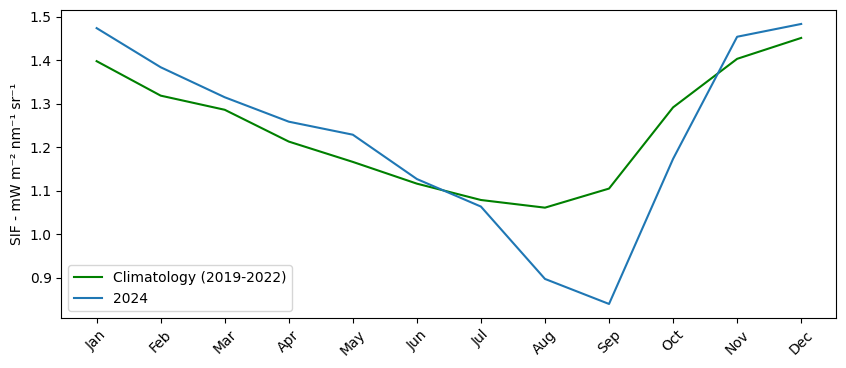

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(months, monthly_means, color='green', label ='Climatology (2019-2023)')
plt.plot(months, sif_monthly[5,:,:,:].mean(axis=(1, 2)), label='2024') 
plt.ylabel("SIF - mW m⁻² nm⁻¹ sr⁻¹")
plt.xticks(rotation=45)
plt.legend()
plt.savefig("pic/sif_climatology.png")
plt.show()

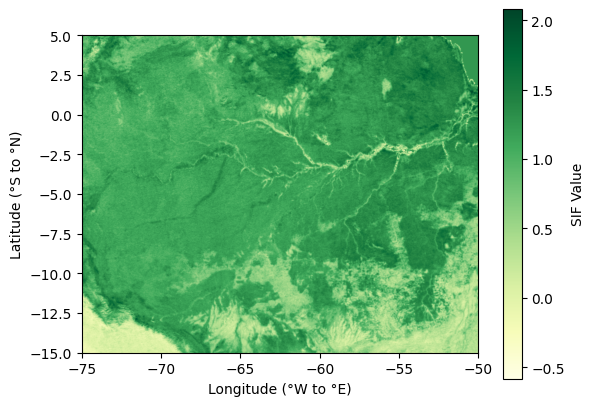

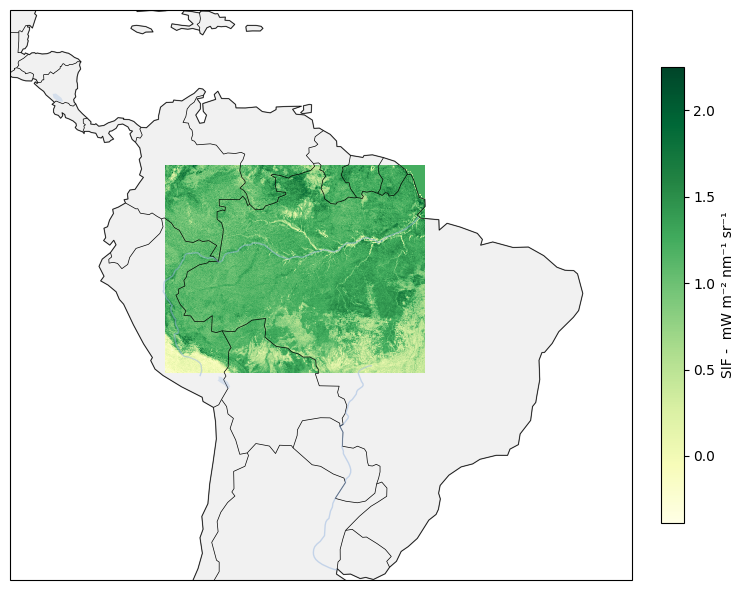

In [ ]:
# Choose a month (0-11)
month_idx = 6 #July
plt.imshow(climatology[month_idx], cmap='YlGn', origin = 'lower',  extent=[lon_min, lon_max, lat_min, lat_max])
plt.colorbar(label='SIF Value')
plt.xlabel("Longitude (°W to °E)")
plt.ylabel("Latitude (°S to °N)")
#plt.title(f"Climatology Map of Amazonas - {months[month_idx]}")
plt.show()

sif_data = climatology[month_idx]

lat = np.linspace(lat_min, lat_max, sif_data.shape[0])
lon = np.linspace(lon_min, lon_max, sif_data.shape[1])
lon2d, lat2d = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-90, -30, -35, 20], crs=ccrs.PlateCarree()) 

ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.RIVERS, alpha=0.5)
ax.add_feature(cfeature.LAKES, alpha=0.3)

im = ax.pcolormesh(lon2d, lat2d, sif_data, cmap="YlGn", shading="auto", transform=ccrs.PlateCarree())

cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.03, shrink=0.8)
cbar.set_label("SIF -  mW m⁻² nm⁻¹ sr⁻¹")
plt.tight_layout()
plt.show()



sif_strided shape: (5, 100, 12, 91, 113)
sif_08_2024_downsampled shape: (91, 113)
sif_patches_combined shape: (500, 12, 91, 113)


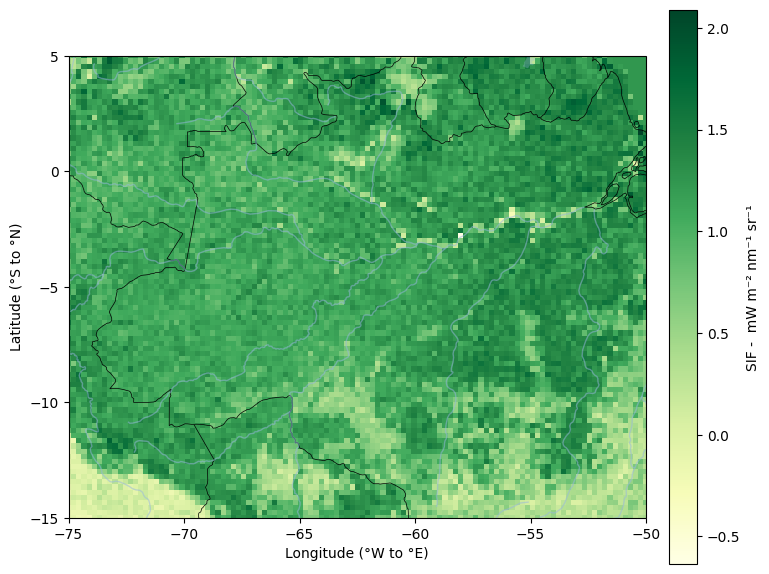

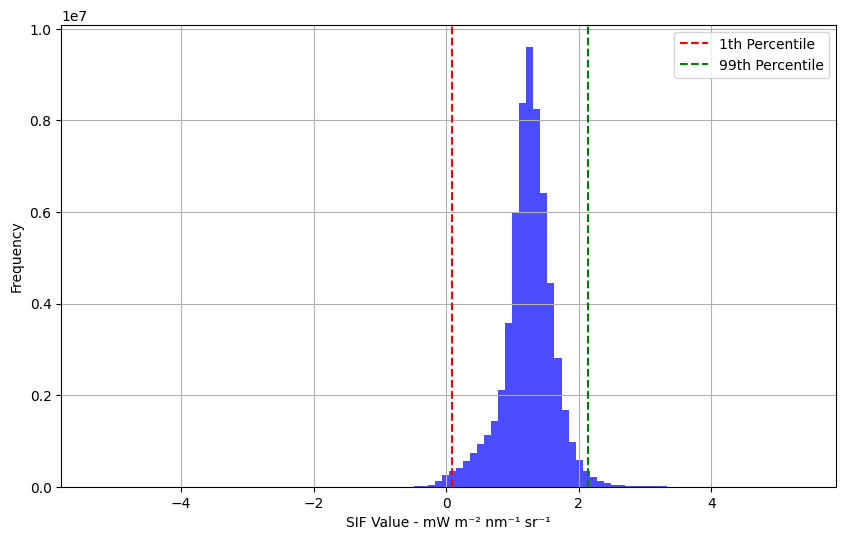

In [ ]:
def create_strided_downsamples(data, modulo):
    years, months, h, w = data.shape

    # Crop to make h and w divisible by modulo
    new_h = (h // modulo) * modulo
    new_w = (w // modulo) * modulo
    cropped = data[..., :new_h, :new_w]

    versions = []
    for row_mod in range(modulo):
        for col_mod in range(modulo):
            version = cropped[..., row_mod::modulo, col_mod::modulo]
            versions.append(version)

    return np.stack(versions, axis=1)
sif_strided = create_strided_downsamples(sif_monthly[0:5],10) 
print("sif_strided shape:", sif_strided.shape)  
sif_08_2024_downsampled = sif_strided[0,2, 7, :, :] 
print("sif_08_2024_downsampled shape:", sif_08_2024_downsampled.shape) 
sif_patches = sif_strided.reshape(-1, 12, sif_strided.shape[-2], sif_strided.shape[-1])
print("sif_patches_combined shape:", sif_patches.shape)


# Plot the selected SIF patch on a Cartopy map
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.RIVERS, alpha=0.5)
ax.add_feature(cfeature.LAKES, alpha=0.3)

xticks = np.linspace(lon_min, lon_max, 6)
yticks = np.linspace(lat_min, lat_max, 5)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())

im = ax.pcolormesh(
    np.linspace(lon_min, lon_max, sif_patches.shape[-1]),
    np.linspace(lat_min, lat_max, sif_patches.shape[-2]),
    sif_08_2024_downsampled,
    cmap="YlGn",
    shading="auto",
    transform=ccrs.PlateCarree()
)
cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.03 , shrink = 1.2)
cbar.set_label("SIF -  mW m⁻² nm⁻¹ sr⁻¹")
plt.xlabel("Longitude (°W to °E)")
plt.ylabel("Latitude (°S to °N)")
plt.show()

sif_patches_flat = sif_patches.flatten()

plt.figure(figsize=(10, 6))
plt.hist(sif_patches_flat, bins=100, color='blue', alpha=0.7)

percentile_5 = np.percentile(sif_patches_flat, 1)
percentile_95 = np.percentile(sif_patches_flat, 99)

plt.axvline(percentile_5, color='red', linestyle='--', label='1th Percentile')
plt.axvline(percentile_95, color='green', linestyle='--', label='99th Percentile')
plt.legend()
plt.xlabel("SIF Value - mW m⁻² nm⁻¹ sr⁻¹")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()



In [ ]:
input_sequences = sif_patches[..., np.newaxis]  #adding a channel dimension
input_seq = Input(shape=(12, sif_patches.shape[2], sif_patches.shape[3], 1))

# Encoder
x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(input_seq)
x = MaxPooling3D((2, 2, 2), padding='same')(x)
x = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling3D((2, 2, 2), padding='same',
                       activity_regularizer=regularizers.l1(1e-5))(x)

# Decoder (mirror of encoder)
x = Conv3D(8, (3, 3, 3), activation='relu', padding='same')(encoded)
x = UpSampling3D((2, 2, 2))(x)
x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)
x = UpSampling3D((2, 2, 2))(x)
x = Cropping3D(((0, 0), (0,  x.shape[2] - input_seq.shape[2]), (0, x.shape[3] - input_seq.shape[3])))(x)
decoded = Conv3D(1, (3, 3, 3), activation='relu', padding='same')(x)

# Autoencoder Model
autoencoder2 = Model(input_seq, decoded)
autoencoder2.compile(optimizer='adam', loss='mse')
autoencoder2.summary()

Model: "functional_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_54 (InputLayer)     │ (None, 12, 91, 113, 1) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_202 (Conv3D)             │ (None, 12, 91, 113,    │           448 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_76 (MaxPooling3D) │ (None, 6, 46, 57, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_203 (Conv3D)             │ (None, 6, 46, 57, 8)   │         3,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_77 (MaxPooling3D) │ (None, 3, 23, 29, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_204 (Conv3D)             │ (None, 3, 23, 29, 8)   │         1,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d_74 (UpSampling3D) │ (None, 6, 46, 58, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_205 (Conv3D)             │ (None, 6, 46, 58, 16)  │         3,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d_75 (UpSampling3D) │ (None, 12, 92, 116,    │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping3d_38 (Cropping3D)      │ (None, 12, 91, 113,    │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_206 (Conv3D)             │ (None, 12, 91, 113, 1) │           433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,553 (37.32 KB)

 Trainable params: 9,553 (37.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
np.random.seed(42)
autoencoder2.fit(input_sequences, input_sequences, 
                epochs=50,
                batch_size=30,
                validation_split=0.2,
                shuffle=True) 


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - loss: 0.1167 - val_loss: 0.1112
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - loss: 0.1059 - val_loss: 0.0943
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - loss: 0.0951 - val_loss: 0.0932
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - loss: 0.0934 - val_loss: 0.0932
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - loss: 0.0917 - val_loss: 0.0917
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - loss: 0.0895 - val_loss: 0.0892
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - loss: 0.0875 - val_loss: 0.0890
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - loss: 0.0863 - val_loss: 0.0870
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - loss: 0.0844 - val_loss: 0.0880
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - loss: 0.0842 - val_loss: 0.0865
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - loss: 0.0834 - val_loss: 0.0851
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - loss: 0.0813 - val_lo

Model saved to autoencoder_sif_model.keras
Model file 'autoencoder_sif_model.keras' exists and is not empty.


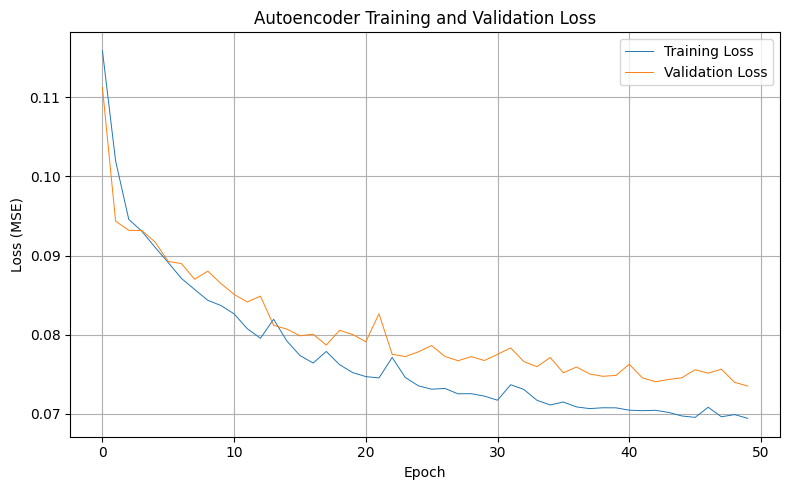

In [ ]:
autoencoder2.save("autoencoder_sif_model.keras")
print("Model saved to autoencoder_sif_model.keras")

model_path = "autoencoder_sif_model.keras"
if os.path.isfile(model_path) and os.path.getsize(model_path) > 0:
    print(f"Model file '{model_path}' exists and is not empty.")
else:
    print(f"Model file '{model_path}' is missing or empty.")

if 'autoencoder' in locals() and hasattr(autoencoder2, 'history') and autoencoder2.history is not None:
    history = autoencoder2.history
else:
    print("Training history not found. Please ensure you have the training history object.")
    history = None

if history is not None:
    if hasattr(history, 'history'):
        hist_dict = history.history
    else:
        hist_dict = history

    plt.figure(figsize=(8, 5))
    plt.plot(hist_dict['loss'], linewidth=0.7,label='Training Loss')
    if 'val_loss' in hist_dict:
        plt.plot(hist_dict['val_loss'], linewidth=0.7, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Autoencoder Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step


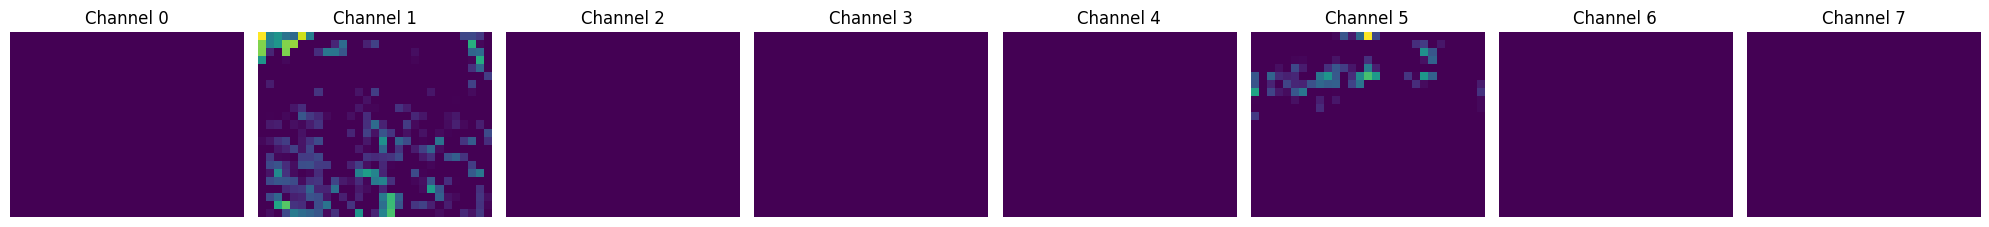

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 391ms/step
Reconstructed shape: (500, 12, 91, 113, 1)


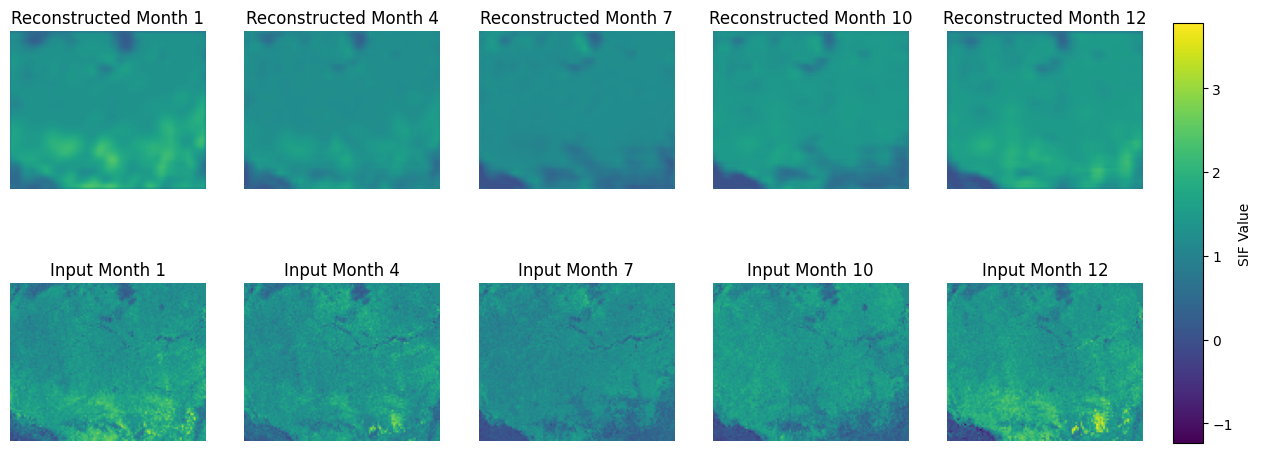

In [ ]:
from keras.models import Model
from sklearn.decomposition import PCA

# Visualize the latent space of the encoder from autoencoder2

# Get the encoder part (up to 'encoded' layer)

# Find the encoded layer by name or index (here, 'encoded' is the variable in the code)
encoder_model = Model(inputs=autoencoder2.input, outputs=encoded)

# Pass the input sequences through the encoder to get latent representations
latent_representations = encoder_model.predict(input_sequences)  # shape: (n_samples, d1, d2, d3, 8)

# Visualize all channels of the latent representation for a specific input (e.g., first validation sample)
sample_idx = 40  # Change this to visualize a different sample
latent_sample = latent_representations[sample_idx]  # shape: (d1, d2, d3, 8)

num_channels = latent_sample.shape[-1]
fig, axs = plt.subplots(1, num_channels, figsize=(20, 3))
for i in range(num_channels):
    axs[i].imshow(latent_sample[2,... , i], cmap='viridis')
    axs[i].set_title(f'Channel {i}')
    axs[i].axis('off')
plt.tight_layout()
plt.show()


reconstruct = autoencoder2.predict(input_sequences)
print("Reconstructed shape:", reconstruct.shape) 

# Visualize the shape of a reconstructed input sample
sample_idx = 100  
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
time_steps = [0, 3, 6, 9, 11]
# Find global min and max for color scaling across all plots
vmin = min(sif_patches[sample_idx, t, :, :].min() for t in time_steps)
vmax = max(sif_patches[sample_idx, t, :, :].max() for t in time_steps)

for i, t in enumerate(time_steps):
    im0 = axes[0, i].imshow(reconstruct[sample_idx, t, :, :], cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
    axes[0, i].set_title(f'Reconstructed Month {t+1}')
    axes[0, i].axis('off')

    im1 = axes[1, i].imshow(sif_patches[sample_idx, t, :, :], cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
    axes[1, i].set_title(f'Input Month {t+1}')
    axes[1, i].axis('off')

fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(im0, cax=cbar_ax, label='SIF Value')

plt.show()

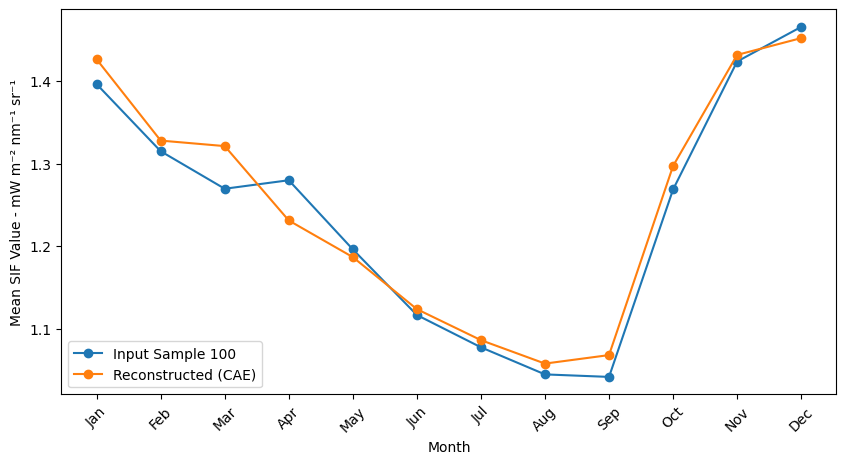

In [ ]:
# Plot mean SIF value per month for input and reconstructed images (averaged over spatial dims)
input_means = np.mean(sif_patches, axis=(2, 3))  
recon_means = np.mean(reconstruct[..., 0], axis=(2, 3))  
sample = 100
plt.figure(figsize=(10, 5))
plt.plot(range(12), input_means[sample], marker='o', label='Input Sample 100')
plt.plot(range(12), recon_means[sample], marker='o', label='Reconstructed (CAE)')
plt.xticks(range(12), months, rotation=45)
plt.xlabel('Month')
plt.ylabel('Mean SIF Value - mW m⁻² nm⁻¹ sr⁻¹')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Reconstructed shape: (6, 12, 91, 113, 1)
Original shape: (6, 12, 91, 113) Reconstructed shape: (6, 12, 91, 113)
Reconstruction error shape: (5, 12, 91, 113)


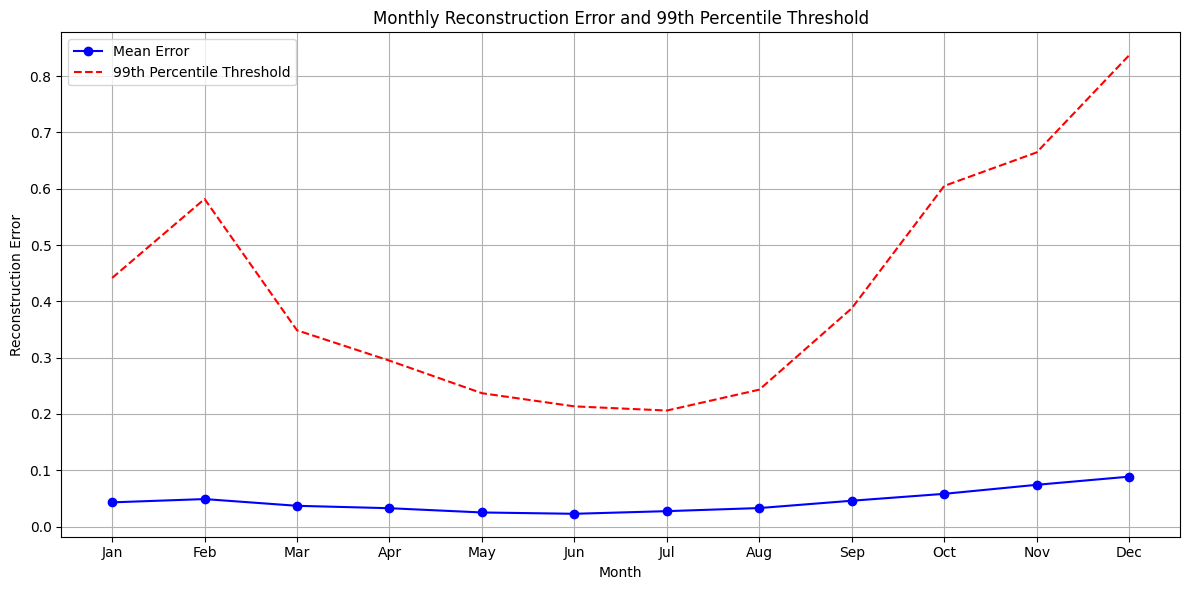

(5, 12, 91, 113)


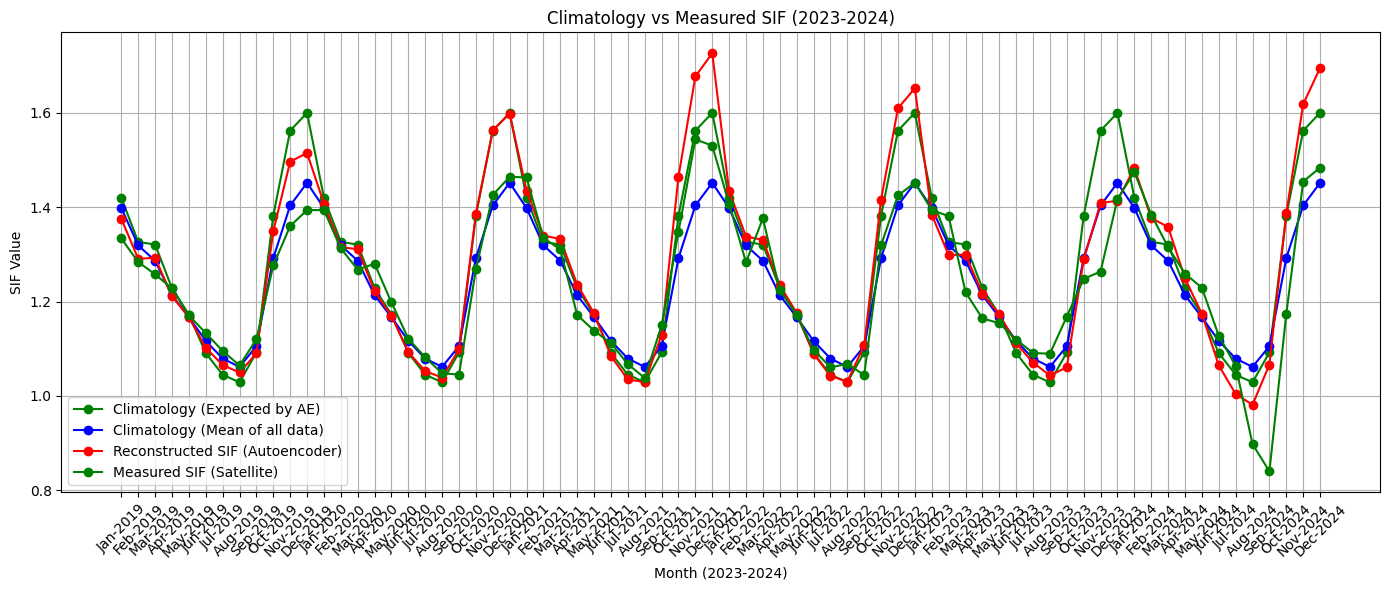

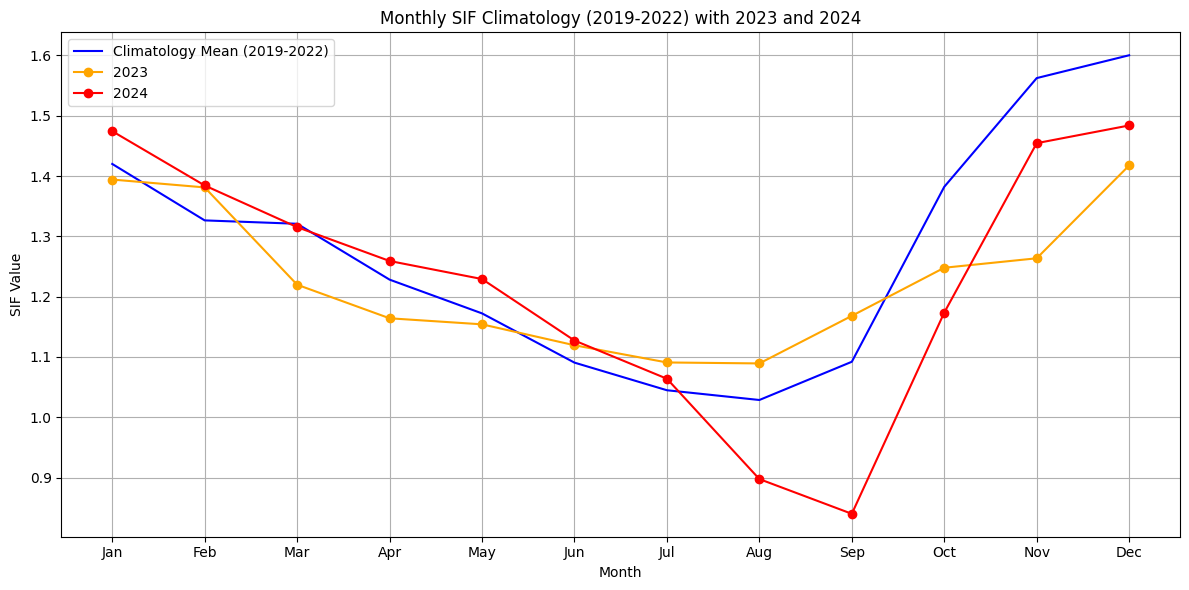

In [945]:
sif_monthly_resized = np.empty((sif_monthly.shape[0], sif_monthly.shape[1], sif_patches.shape[2], sif_patches.shape[3]))
for year_idx in range(sif_monthly.shape[0]):
    for month_idx in range(sif_monthly.shape[1]):
        sif_monthly_resized[year_idx, month_idx] = resize(
            sif_monthly[year_idx, month_idx],
            (sif_patches.shape[2], sif_patches.shape[3]),
            anti_aliasing=True
        )

original = sif_monthly_resized[..., np.newaxis]  
reconstructed = autoencoder2.predict(original)
print("Reconstructed shape:", reconstructed.shape)  # Should be (6, 12, 91, 113, 1)
reconstructed = reconstructed[..., 0] 
original = original[... , 0] 
print("Original shape:", original.shape, "Reconstructed shape:", reconstructed.shape)


reconstruction_error_pixel = (original[0:5] - reconstructed[0:5]) ** 2 #MSE, leave 2024 out to compute threshold
print("Reconstruction error shape:", reconstruction_error_pixel.shape) 

#this threshold is for general areas, not pixel per pixel 
thresholds_per_month = np.percentile(reconstruction_error_pixel, 99, axis=(0,2,3))  

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
 
mean_errors = np.mean(reconstruction_error_pixel, axis=(0,2,3)) 

plt.figure(figsize=(12, 6))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.plot(range(12), mean_errors, 'b-', label='Mean Error', marker='o')
plt.plot(range(12), thresholds_per_month, 'r--', label='99th Percentile Threshold')
plt.xticks(range(12), months)
plt.xlabel('Month')
plt.ylabel('Reconstruction Error')
plt.title('Monthly Reconstruction Error and 99th Percentile Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


anomalies_month = reconstruction_error_pixel > thresholds_per_month.reshape(1, 12, 1, 1)  #anomalies per month not subject to pixel
print(anomalies_month.shape)

extended_months = [f"{month}-{year}" for year in [2019, 2020, 2021, 2022, 2023, 2024] for month in months]

# Concatenate the climatology and measured SIF for 2023-2024
climatology_24_months = np.mean(climatology, axis = (1,2)) 
climatology_24_months = np.tile(climatology_24_months, 6) 
climatology_AE_mean = np.mean(reconstructed, axis = (0,2,3))
climatology_AE = np.tile(climatology_AE_mean, 6)
AE_reconstruction = np.mean(reconstructed, axis = (2,3)).flatten() 
sif_measured_24_months = np.mean(sif_monthly, axis = (2,3)).flatten() 

plt.figure(figsize=(14, 6))
plt.plot(extended_months, climatology_AE, label="Climatology (Expected by AE)", color="green", marker="o")
plt.plot(extended_months, climatology_24_months, label="Climatology (Mean of all data)", color="blue", marker="o")
plt.plot(extended_months, AE_reconstruction, label="Reconstructed SIF (Autoencoder)", color="red", marker="o")
plt.plot(extended_months, sif_measured_24_months, label="Measured SIF (Satellite)", color="green", marker="o")
plt.xlabel("Month (2023-2024)")
plt.ylabel("SIF Value")
plt.title("Climatology vs Measured SIF (2023-2024)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(months, climatology_AE_mean, label='Climatology Mean (2019-2022)', color='blue')
plt.plot(months, np.nanmean(sif_monthly_resized[4], axis=(1, 2)), label='2023', color='orange', marker='o')
plt.plot(months, np.nanmean(sif_monthly_resized[5], axis=(1, 2)), label='2024', color='red', marker='o')
plt.xlabel('Month')
plt.ylabel('SIF Value')
plt.title('Monthly SIF Climatology (2019-2022) with 2023 and 2024')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# # Compute reconstruction error on sif_monthly_downsized
# sif_monthly_downsized_expanded = sif_monthly_resized[..., np.newaxis]  # Add channel dimension if needed

# reconstructed_downsized = np.zeros_like(sif_monthly_downsized_expanded)
# for i in range(sif_monthly_downsized_expanded.shape[0]):
#     pred = autoencoder2.predict(sif_monthly_downsized_expanded[None, i, ...])
#     reconstructed_downsized[i] = pred

# original_downsized = sif_monthly_downsized_expanded[..., 0]
# reconstruction_error_downsized = (original_downsized - reconstructed_downsized[..., 0]) ** 2

# print("Reconstruction error shape on downsized:", np.nanmean(reconstruction_error_downsized))


Reconstruction error shape: (6, 12, 91, 113)


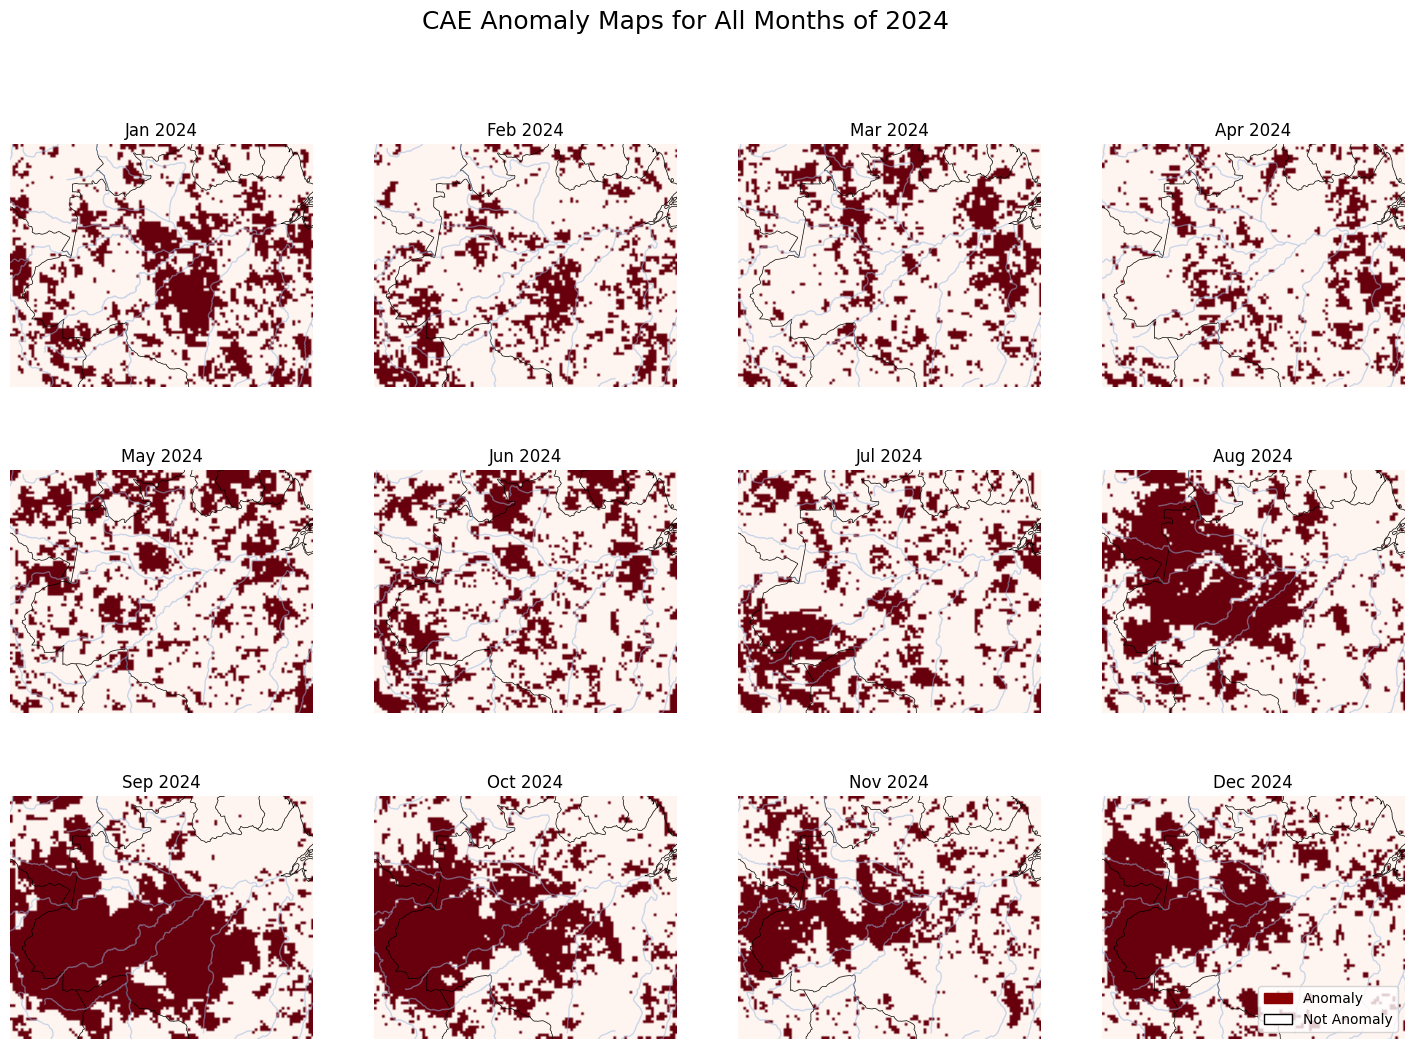

Anomaly Percentages Table for 2024:
   Month  Anomaly % (2024)
0    Jan             29.74
1    Feb             21.07
2    Mar             22.75
3    Apr             18.40
4    May             28.24
5    Jun             28.66
6    Jul             26.86
7    Aug             37.76
8    Sep             48.69
9    Oct             41.04
10   Nov             28.97
11   Dec             36.72


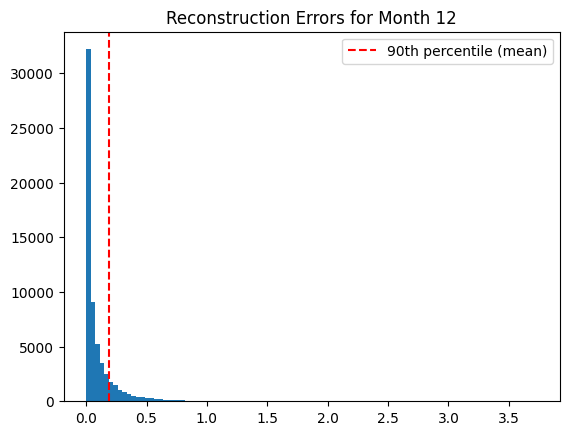

In [ ]:
#computing threshold for each pixel and each month without 2024
thresholds_per_pixel = np.percentile(reconstruction_error_pixel[0:5], 99, axis = 0) 

#including 2024
reconstruction_error_pixel_all = (original - reconstructed) ** 2 
print("Reconstruction error shape:", reconstruction_error_pixel_all.shape)  

anomalies_pixel = reconstruction_error_pixel_all > thresholds_per_pixel

anomaly_list = []

for year in range(anomalies_pixel.shape[0]):
    for month in range(12):
        lat_idx, lon_idx = np.where(anomalies_pixel[year, month])
        for i in range(len(lat_idx)):
            anomaly_list.append({
                'year': 2019 + year,  
                'month': month + 1,
                'lat_idx': lat_idx[i],
                'lon_idx': lon_idx[i],
                'error': reconstruction_error_pixel_all[year, month, lat_idx[i], lon_idx[i]]
            })

anomaly_cnn_df = pd.DataFrame(anomaly_list)


fig, axs = plt.subplots(3, 4, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle("CAE Anomaly Maps for All Months of 2024", fontsize=18)

for month_idx in range(12):
    ax = axs[month_idx // 4, month_idx % 4]
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.RIVERS, alpha=0.5)
    anomaly_map = anomalies_pixel[5, month_idx]  # year_idx = 5 for 2024
    im = ax.imshow(anomaly_map, cmap='Reds', origin='lower', extent=[lon_min, lon_max, lat_min, lat_max], transform=ccrs.PlateCarree())
    ax.set_title(f"{months[month_idx]} 2024")
    ax.axis('off')

legend_elements = [
    Patch(facecolor='darkred', edgecolor='darkred', label='Anomaly'),
    Patch(facecolor='white', edgecolor='black', label='Not Anomaly')
]
ax.legend(handles=legend_elements, loc='lower right', frameon=True)
plt.show()

anomaly_percentages_2024 = []
for month in range(12):
    mask = anomalies_pixel[5, month]
    total = np.isfinite(mask).sum()
    anomalies = np.nansum(mask)
    percent = (anomalies / total) * 100 if total > 0 else np.nan
    anomaly_percentages_2024.append(percent)

anomaly_percentages_2024_cnn_df = pd.DataFrame({
    'Month': months,
    'Anomaly % (2024)': np.round(anomaly_percentages_2024, 2)
})

print("Anomaly Percentages Table for 2024:")
print(anomaly_percentages_2024_cnn_df)


plt.hist(reconstruction_error_pixel_all[:, month_idx].flatten(), bins=100)
plt.axvline(thresholds_per_month[month_idx].mean(), color='r', linestyle='--', label='90th percentile (mean)')
plt.title(f"Reconstruction Errors for Month {month_idx + 1}")
plt.legend()
plt.show()


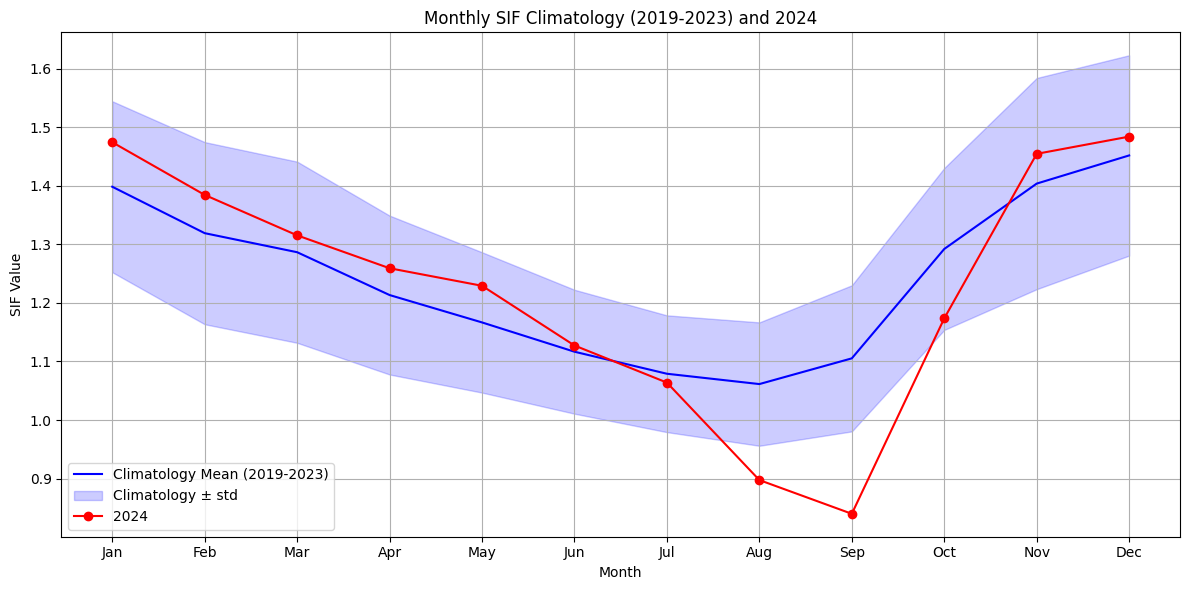

/var/folders/wj/pgnjjx3n5dg6p90187_803300000gn/T/ipykernel_13692/551639909.py:20: RuntimeWarning: divide by zero encountered in divide
  z_scores = (sif_monthly[5:] - climatology_mean) / climatology_std
/var/folders/wj/pgnjjx3n5dg6p90187_803300000gn/T/ipykernel_13692/551639909.py:20: RuntimeWarning: invalid value encountered in divide
  z_scores = (sif_monthly[5:] - climatology_mean) / climatology_std


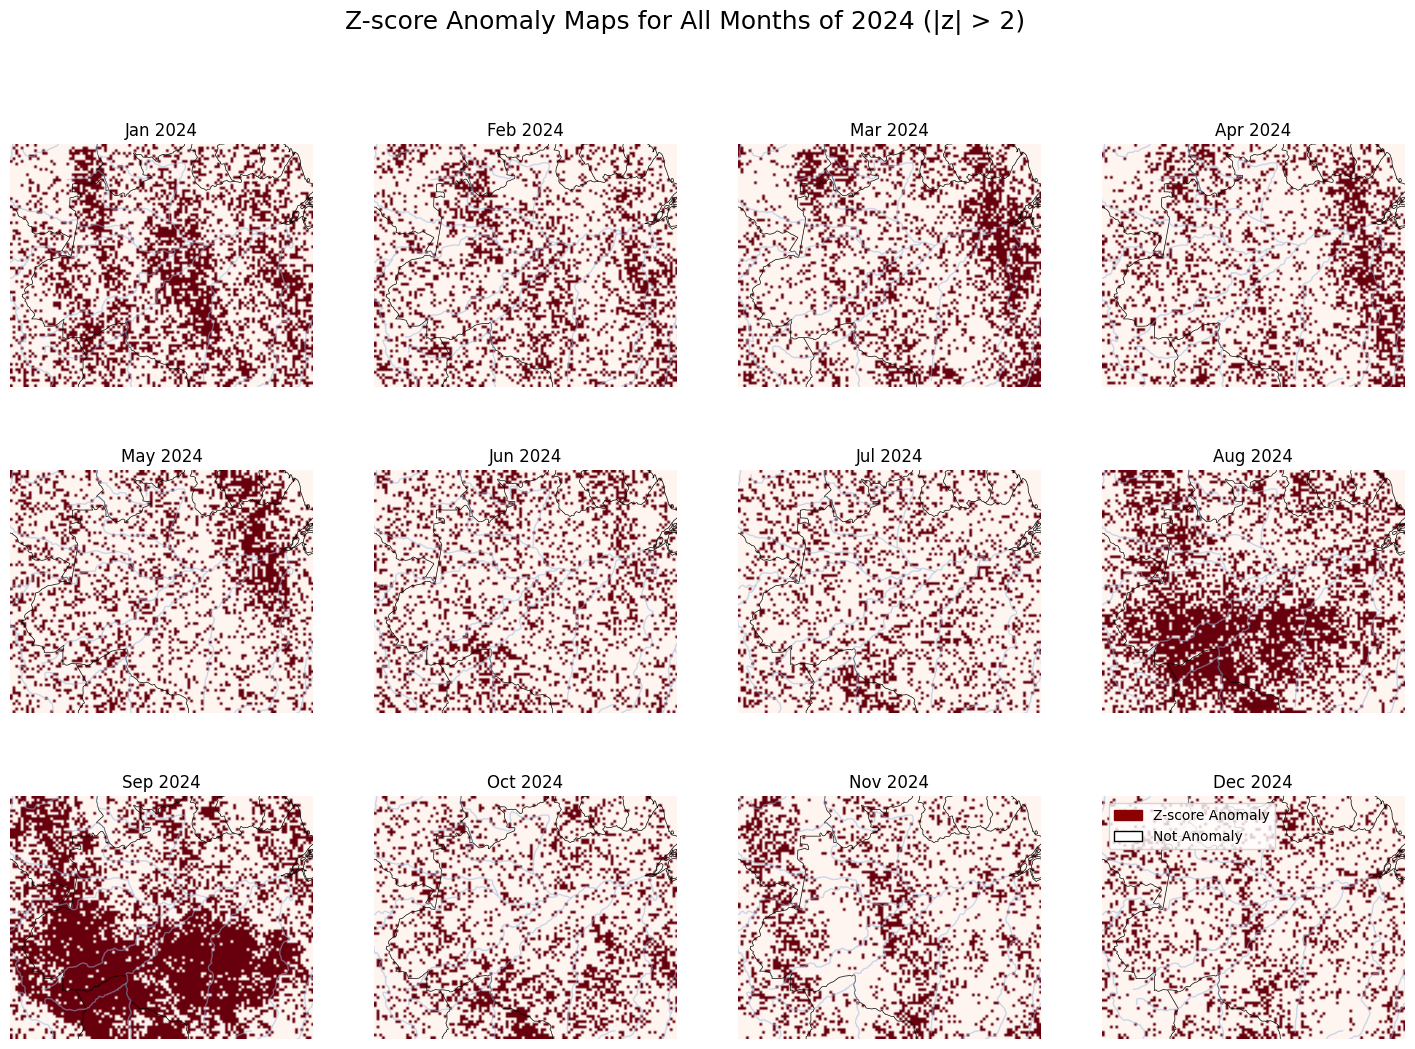

In [ ]:
climatology_mean = np.mean(sif_monthly[:5], axis=0)  
climatology_std = np.std(sif_monthly[:5], axis=0)   
clim_mean = np.nanmean(climatology_mean, axis=(1, 2))  
clim_std = np.nanmean(climatology_std, axis=(1, 2))    
months_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize=(12, 6))
plt.plot(months_labels, clim_mean, label='Climatology Mean (2019-2023)', color='blue')
plt.fill_between(months_labels, clim_mean - clim_std, clim_mean + clim_std, color='blue', alpha=0.2, label='Climatology ± std')
plt.plot(months_labels, np.nanmean(sif_monthly[5], axis=(1, 2)), label='2024', color='red', marker='o')
plt.xlabel('Month')
plt.ylabel('SIF Value')
plt.title('Monthly SIF Climatology (2019-2023) and 2024')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#z-score for each pixel and each month
z_scores = (sif_monthly[5:] - climatology_mean) / climatology_std

#flag anomalies where |z| > 2
anomaly_z = np.abs(z_scores) > 2 

anomaly_map = np.empty((12, 91, 113), dtype=bool)
for m in range(12):
    anomaly_map[m] = resize(
        anomaly_z[0, m].astype(float),
        (91, 113),
        order=0, 
        preserve_range=True,
        anti_aliasing=False
    ).astype(bool)


fig, axs = plt.subplots(3, 4, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle("Z-score Anomaly Maps for All Months of 2024 (|z| > 2)", fontsize=18)

for month_idx in range(12):
    ax = axs[month_idx // 4, month_idx % 4]
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.RIVERS, alpha=0.5)
    im = ax.imshow(anomaly_map[month_idx], cmap='Reds', origin='lower', extent=[lon_min, lon_max, lat_min, lat_max], transform=ccrs.PlateCarree())
    ax.set_title(f"{months[month_idx]} 2024")
    ax.axis('off')

legend_elements = [
    Patch(facecolor='DarkRed', edgecolor='DarkRed', label='Z-score Anomaly'),
    Patch(facecolor='white', edgecolor='black', label='Not Anomaly')
]
ax.legend(handles=legend_elements, loc='upper left', frameon=True)
plt.show()

In [954]:
print("Anomaly mask shape:", anomaly_z.shape)
anomaly_percentages_z = []


year_percentages = []
for month_idx in range(12):
    mask = anomaly_z[0, month_idx]
    total = np.isfinite(mask).sum() 
    anomalies = np.nansum(mask)
    percent = (anomalies / total) * 100 if total > 0 else np.nan
    year_percentages.append(percent)
anomaly_percentages_z.append(year_percentages)


months_short = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
anomaly_z_df = pd.DataFrame(np.array(anomaly_percentages_z[0]).T, columns=[2024], index=months_short)

print("Percentage of anomalies in 2024 (z-score method):")
print(anomaly_z_df.round(3))



Anomaly mask shape: (1, 12, 911, 1137)
Percentage of anomalies in 2024 (z-score method):
       2024
Jan  33.443
Feb  24.114
Mar  26.639
Apr  23.936
May  24.337
Jun  21.640
Jul  19.583
Aug  41.020
Sep  52.830
Oct  22.509
Nov  21.215
Dec  18.213


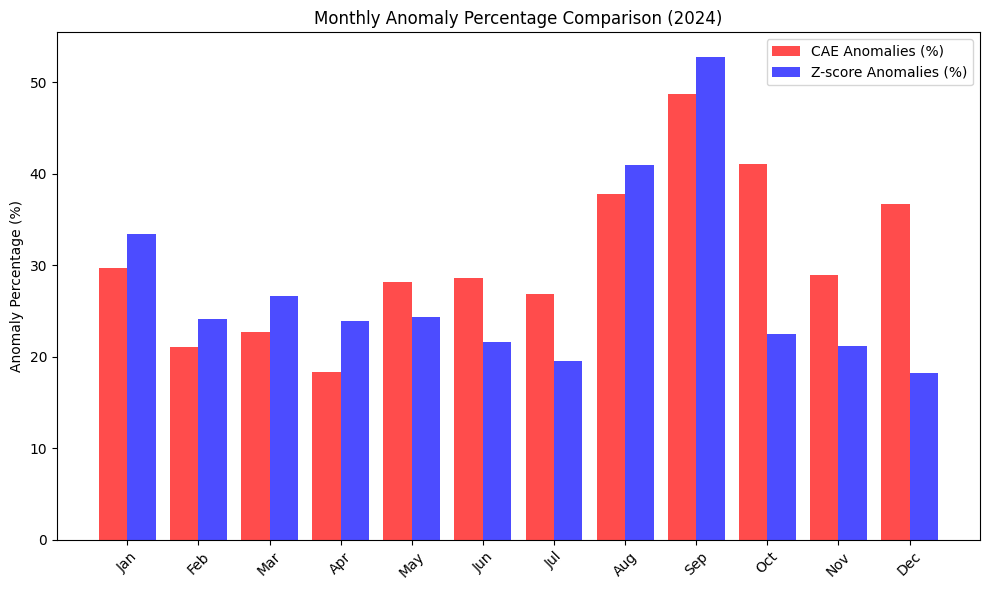

In [ ]:
mean_anomaly_zscore_2024 = np.array(anomaly_percentages_z[0]) 
mean_anomaly_cae_2024 = np.array(anomaly_percentages_2024)  

plt.figure(figsize=(10, 6))
bar_width = 0.4
x = np.arange(len(months))

plt.bar(x - bar_width/2, mean_anomaly_cae_2024, width=bar_width, label='CAE Anomalies (%)', color='red', alpha=0.7)
plt.bar(x + bar_width/2, mean_anomaly_zscore_2024, width=bar_width, label='Z-score Anomalies (%)', color='blue', alpha=0.7)

plt.xticks(x, months, rotation=45)
plt.ylabel('Anomaly Percentage (%)')
plt.title('Monthly Anomaly Percentage Comparison (2024)')
plt.legend()
plt.tight_layout()
plt.show()

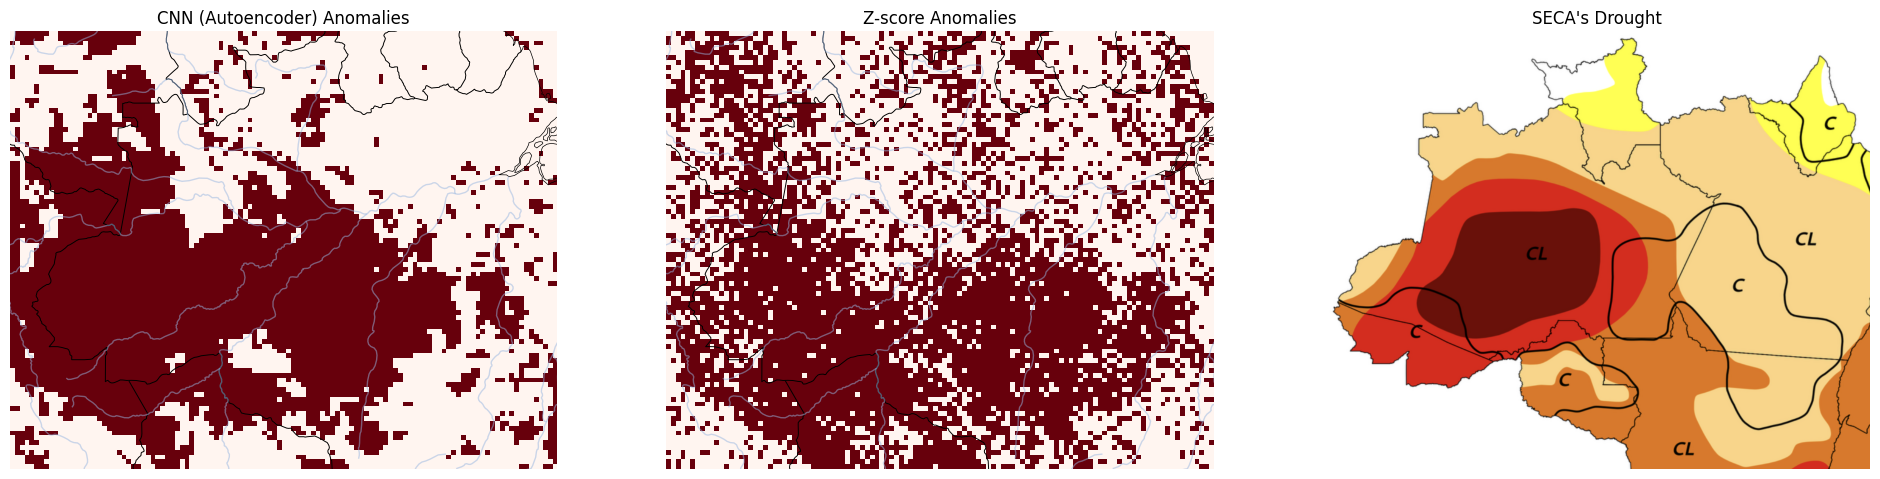

In [958]:
cnn_anomalies_2024 = anomalies_pixel[5] 
zscore_anomalies_2024 = anomaly_z[0] 

month_idx = 8 #september

zscore_anomalies_2024_resized = np.empty((12, 91, 113), dtype=bool)
for m in range(12):
    zscore_anomalies_2024_resized[m] = resize(
        zscore_anomalies_2024[m].astype(float),
        (91, 113),
        order=0,  # nearest-neighbor
        preserve_range=True,
        anti_aliasing=False
    ).astype(bool)

#secas image 
secas_septem_img = mpimg.imread('secas_sept.png')

fig = plt.figure(figsize=(24, 6))

proj = ccrs.PlateCarree()
extent = [lon_min, lon_max, lat_min, lat_max]

# CNN-based anomaly map
ax0 = plt.subplot(1, 3, 1, projection=proj)
ax0.set_extent(extent, crs=proj)
ax0.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
ax0.add_feature(cfeature.BORDERS, linewidth=0.7)
ax0.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax0.add_feature(cfeature.RIVERS, alpha=0.5)
im0 = ax0.imshow(cnn_anomalies_2024[month_idx], cmap='Reds', origin='lower', extent=extent, transform=proj)
ax0.set_title("CNN (Autoencoder) Anomalies")
ax0.axis('off')

# z-score-based anomaly map
ax1 = plt.subplot(1, 3, 2, projection=proj)
ax1.set_extent(extent, crs=proj)
ax1.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="black", alpha=0.3)
ax1.add_feature(cfeature.BORDERS, linewidth=0.7)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.RIVERS, alpha=0.5)
im1 = ax1.imshow(zscore_anomalies_2024_resized[month_idx], cmap='Reds', origin='lower', extent=extent, transform=proj)
ax1.set_title("Z-score Anomalies")
ax1.axis('off')

# SECA's October image
ax2 = plt.subplot(1, 3, 3, projection=proj)
ax2.set_extent(extent, crs=proj)
im2 = ax2.imshow(secas_septem_img, extent=extent, transform=proj)
ax2.set_title("SECA's Drought")
ax2.axis('off')


plt.show()


In [965]:

# find all secas_*.png images in the current directory
secas_images = sorted(glob.glob('secas_*.png'))

#idea is to create a drought mask for each image based on the white pixels
drought_masks = {}
for img_path in secas_images:
    imga = mpimg.imread(img_path)
    img = cv2.cvtColor(imga, cv2.COLOR_BGR2RGB)
    target_shape = [113, 91]
    img_rgb_resized = np.flipud(cv2.resize(img, target_shape, interpolation=cv2.INTER_NEAREST))
    white_threshold = 0.3
    white_pixels = np.all(img_rgb_resized > white_threshold, axis=-1)
    drought_mask = (~white_pixels).astype(int)
    drought_masks[img_path] = drought_mask
    print(f"{img_path}: unique values {np.unique(drought_mask)}, shape {drought_mask.shape}")
imga = mpimg.imread('secas_sept.png')

drought_mask = drought_masks['secas_sept.png']

secas_aug.png: unique values [0 1], shape (91, 113)
secas_dec.png: unique values [0 1], shape (91, 113)
secas_jan.png: unique values [0 1], shape (91, 113)
secas_jun.png: unique values [0 1], shape (91, 113)
secas_nov.png: unique values [0 1], shape (91, 113)
secas_oct.png: unique values [0 1], shape (91, 113)
secas_sept.png: unique values [0 1], shape (91, 113)


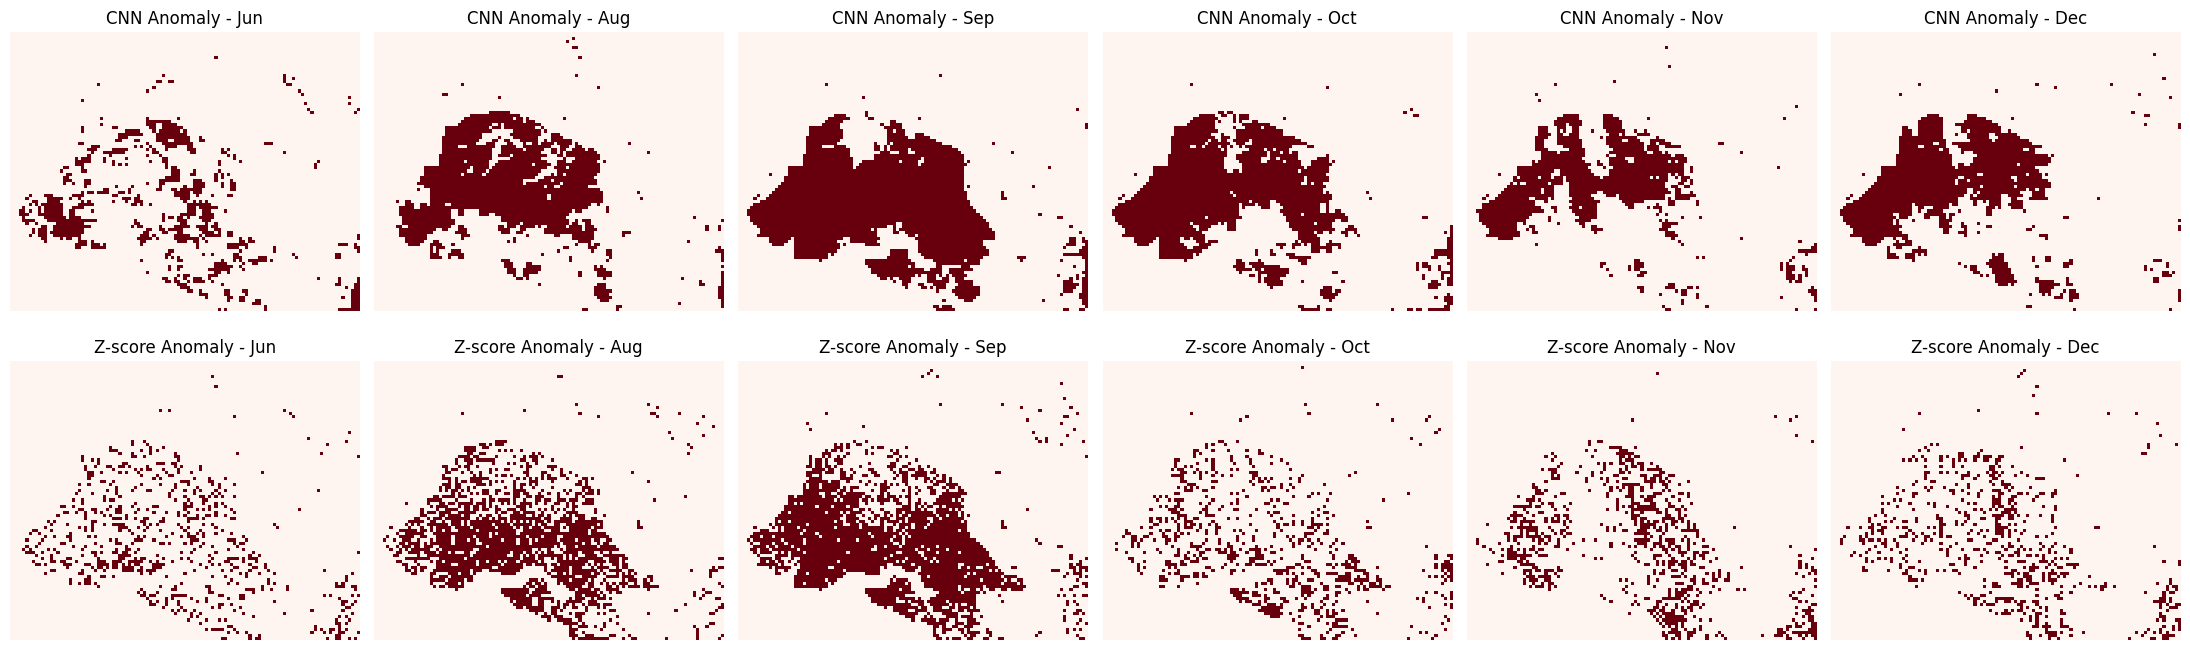

In [966]:
# plot only brazil's anomalies for selected months: June (5), August (7), September (8), October (9), November (10), December (11)
selected_months = [5, 7, 8, 9, 10, 11]
fig, axs = plt.subplots(2, 6, figsize=(22, 7))

for i, m_idx in enumerate(selected_months):
    masked_cnn = np.where(drought_mask == 1, cnn_anomalies_2024[m_idx], 0)
    axs[0, i].imshow(masked_cnn, cmap='Reds', origin='lower', extent=[lon_min, lon_max, lat_min, lat_max])
    axs[0, i].set_title(f'CNN Anomaly - {months[m_idx]}')
    axs[0, i].axis('off')
    
    masked_zscore = np.where(drought_mask == 1, zscore_anomalies_2024_resized[m_idx], 0)
    axs[1, i].imshow(masked_zscore, cmap='Reds', origin='lower', extent=[lon_min, lon_max, lat_min, lat_max])
    axs[1, i].set_title(f'Z-score Anomaly - {months[m_idx]}')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()


In [971]:
#compute Dice and IoU for selected months of masked anomalies (CNN) vs Secas drought mask
selected_months = [5, 7, 8, 9, 10, 11]
dice_scores = []
iou_scores = []

for m_idx in selected_months:
    masked_anomaly_cnn = np.where(drought_mask == 1, cnn_anomalies_2024[m_idx], 0)
    intersection = np.sum(masked_anomaly_cnn * drought_mask)
    total_pixels = np.sum(masked_anomaly_cnn) + np.sum(drought_mask)
    dice = 1.0 if total_pixels == 0 else 2 * intersection / total_pixels
    dice_scores.append(dice)

    intersection_iou = np.sum(cnn_anomalies_2024[m_idx] * drought_mask)
    union = np.sum((cnn_anomalies_2024[m_idx] + drought_mask) > 0)
    iou = 1.0 if union == 0 else intersection_iou / union
    iou_scores.append(iou)

for i, m_idx in enumerate(selected_months):
    print(f"{months[m_idx]}: Dice = {dice_scores[i]:.4f}, IoU = {iou_scores[i]:.4f}")



Jun: Dice = 0.4125, IoU = 0.1634
Aug: Dice = 0.7028, IoU = 0.3434
Sep: Dice = 0.8665, IoU = 0.4552
Oct: Dice = 0.7674, IoU = 0.3905
Nov: Dice = 0.5628, IoU = 0.2669
Dec: Dice = 0.6501, IoU = 0.2996


In [970]:
#compute Dice and IoU for selected months of masked anomalies (CNN) vs Secas drought mask
selected_months = [5, 7, 8, 9, 10, 11]
dice_scores_z = []
iou_scores_z = []

for m_idx in selected_months:
    masked_anomaly_z = np.where(drought_mask == 1, zscore_anomalies_2024_resized[m_idx], 0)
    intersection = np.sum(masked_anomaly_z * drought_mask)
    total_pixels = np.sum(masked_anomaly_z) + np.sum(drought_mask)
    dice = 1.0 if total_pixels == 0 else 2 * intersection / total_pixels
    dice_scores_z.append(dice)

    intersection_iou = np.sum(zscore_anomalies_2024_resized[m_idx] * drought_mask)
    union = np.sum((zscore_anomalies_2024_resized[m_idx] + drought_mask) > 0)
    iou = 1.0 if union == 0 else intersection_iou / union
    iou_scores_z.append(iou)

for i, m_idx in enumerate(selected_months):
    print(f"{months[m_idx]}: Dice = {dice_scores_z[i]:.4f}, IoU = {iou_scores_z[i]:.4f}")



Jun: Dice = 0.3331, IoU = 0.1381
Aug: Dice = 0.6871, IoU = 0.3100
Sep: Dice = 0.7971, IoU = 0.3487
Oct: Dice = 0.3851, IoU = 0.1664
Nov: Dice = 0.4077, IoU = 0.1872
Dec: Dice = 0.3367, IoU = 0.1518


In [939]:
#If we want to compute the average of the TROPOSIF dataset over the relevant pixels used in the retrieval method follow the following:

# # Compute mean SIF in January 2024 over area: lat -25 to 10, lon -65 to -60
# year_idx_2024 = years.index(2024)
# month_idx_jan = 0  # January

# # Get latitude and longitude arrays for the grid
# lat_grid = np.linspace(lat_min, lat_max, sif_monthly.shape[2])
# lon_grid = np.linspace(lon_min, lon_max, sif_monthly.shape[3])

# # Find indices for the specified lat/lon bounds
# lat_mask = (lat_grid >= -25) & (lat_grid <= 10)
# lon_mask = (lon_grid >= -65) & (lon_grid <= -60)

# # Extract the region and compute the mean
# sif_jan_2024_region = sif_monthly[year_idx_2024, month_idx_jan][np.ix_(lat_mask, lon_mask)]
# mean_sif_jan_2024_region = np.nanmean(sif_jan_2024_region)
# median_sif_jan_2024_region = np.nanmedian(sif_jan_2024_region)
# print("Mean SIF in January 2024 over lat -25 to 10, lon -65 to -60:", mean_sif_jan_2024_region)
# print("median:", median_sif_jan_2024_region)